In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import cm
import hj_reachability as hj
from scipy.interpolate import interpn
from scipy.optimize import minimize

# Define our 2D drone system

In [3]:
from hj_reachability import dynamics
from hj_reachability import sets

u_bar = 1.0
d_bar = 1.0

class Drone2D(dynamics.ControlAndDisturbanceAffineDynamics):

  def __init__(self,
               k=12.0,
               g=9.8,
               u_bar=u_bar,
               d_bar=d_bar):
    self.k = k
    self.g = g
    control_mode = 'max'
    disturbance_mode = 'min'
    control_space = sets.Box(jnp.array([-u_bar]), jnp.array([u_bar]))
    disturbance_space = sets.Box(jnp.array([-d_bar]), jnp.array([d_bar]))
    super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

  def open_loop_dynamics(self, state, time):
    _, v = state
    return jnp.array([v, -self.g])

  def control_jacobian(self, state, time):
    return jnp.array([[0.], [self.k]])

  def disturbance_jacobian(self, state, time):
    return jnp.array([[0.], [1.0]])

# Compute the Value Function

In [4]:
# Define the computation grid for numerically solving the PDE
grid_pts = 51
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(np.array([-2., -4.]),
                np.array([+2., +4.])),
    (grid_pts, grid_pts))

# Define the implicit function l(x) for the failure set
failure_values = 1.5 - jnp.abs(grid.states[..., 0])

# Solver settings
times = np.linspace(0, -5, 11, endpoint=True)
solver_settings = hj.SolverSettings.with_accuracy('very_high',
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

# Compute the value function by solving the PDE
dynamics = Drone2D()
values = hj.solve(solver_settings, dynamics, grid, times, failure_values)

100%|##########|  5.0000/5.0 [00:00<00:00,  8.40sim_s/s]


# Visualize the computed value function and BRT

In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

vbar = 1.5
def plot_value_function(t):
  ti = np.argwhere(np.isclose(times, t)).item()

  plt.figure()
  plt.title(f'$V(x, {t})$')
  plt.xlabel('$v_z$ (m/s)')
  plt.ylabel('$z$ (m)')

  plt.pcolormesh(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[ti],
      cmap='RdBu',
      vmin=-vbar, vmax=vbar
  )
  plt.colorbar()
  plt.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[ti],
      levels=0,
      colors='k'
  )
  plt.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      failure_values,
      levels=0,
      colors='r'
  )
  plt.grid()
  plt.show()

interact(
    plot_value_function,
    t=FloatSlider(value=0., min=-5., max=0., step=0.5)
)

interactive(children=(FloatSlider(value=0.0, description='t', max=0.0, min=-5.0, step=0.5), Output()), _dom_cl…

<function __main__.plot_value_function(t)>

# Define and simulate the nominal controller

In [6]:
# Nominal control: always [1]
def nominal_controller(state):
    return np.array([1.0])

# Nominal disturbance: always [-1]
def nominal_disturbance(state):
    return np.array([-1.0])

# Dynamics function
def dynamics_func(state, control, disturbance, dt=0.05):
    return state + dt*np.array([state[1], dynamics.k*control[0]-dynamics.g+disturbance[0]])

# Simulate nominal controller
def simulate(initial_state, controller, T=5.0, dt=0.05):
    traj = [initial_state]
    ctrls = []
    t_steps = int(T / dt)
    state = initial_state.copy()
    for _ in range(t_steps):
        u = controller(state)
        ctrls.append(u.copy())
        d = nominal_disturbance(state)
        state = dynamics_func(state, u, d, dt)
        traj.append(state.copy())
    return np.array(traj), np.array(ctrls)

# Visualization Utils

In [7]:
def plot_trajectories(traj_ctrl_pairs, title="Trajectories"):
  fig, axs = plt.subplots(1, 2, figsize=(10, 3))
  colors = list(cm.tab10.colors)

  # Plot state trajectories
  ax = axs[0]
  for idx, (traj, _) in enumerate(traj_ctrl_pairs):
    c = colors[idx % len(colors)]
    ax.plot(traj[:, 1], traj[:, 0], color=c)
    ax.plot(traj[0, 1], traj[0, 0], 'o', color=c)
    ax.plot(traj[-1, 1], traj[-1, 0], 'x', color=c)
    ax.set_title(title + " - State")
    ax.set_xlabel('$v_z$ (m/s)')
    ax.set_ylabel('$z$ (m)')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-2, 2)

  ax.pcolormesh(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[-1],
      cmap='RdBu',
      vmin=-vbar, vmax=vbar
  )
  # ax.colorbar()

  ax.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[-1],
      levels=0,
      colors='k'
  )
  ax.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      failure_values,
      levels=0,
      colors='r'
  )

  # Plot u over time
  ax = axs[1]
  for idx, (_, ctrl) in enumerate(traj_ctrl_pairs):
      c = colors[idx % len(colors)]
      t = np.linspace(0, len(ctrl)*0.05, len(ctrl))
      ax.plot(t, ctrl[:, 0], color=c)
  ax.set_title(title + " - Control")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("u")

  plt.show()

# Behavior of the Nominal Controller

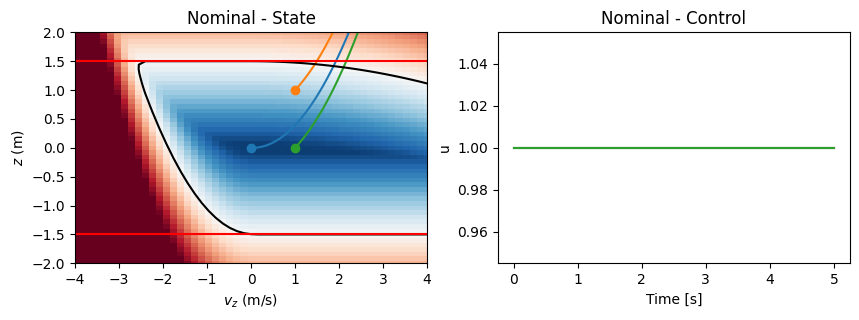

In [8]:
# Initial conditions
initial_conditions = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([0.0, 1.0])
]

# Nominal trajectories
trajs1 = [simulate(ic, nominal_controller) for ic in initial_conditions]
plot_trajectories(trajs1, title="Nominal")

# Least Restrictive Controller

In [9]:
converged_value = values[-1]
grads = grid.grad_values(converged_value, solver_settings.upwind_scheme)

# Compute the value function
def v(state):
  return interpn(
      ([np.array(v) for v in grid.coordinate_vectors]),
      np.array(converged_value),
      state,
      method='linear',
      bounds_error=False,
      fill_value=None
  )

# Compute the value function gradient
def grad_v(state):
  grad_value_x1 = interpn(
      ([np.array(v) for v in grid.coordinate_vectors]),
      np.array(grads[:, :, 0]),
      state,
      method='linear',
      bounds_error=False,
      fill_value=None
  )
  grad_value_x2 = interpn(
      ([np.array(v) for v in grid.coordinate_vectors]),
      np.array(grads[:, :, 1]),
      state,
      method='linear',
      bounds_error=False,
      fill_value=None
  )
  return np.array([grad_value_x1, grad_value_x2])[:, 0]

# Least Restrictive Controller
def lrc(state):
    if v(state) > 0:
        return nominal_controller(state)
    else:
        return dynamics.optimal_control(state, 0.0, grad_v(state))

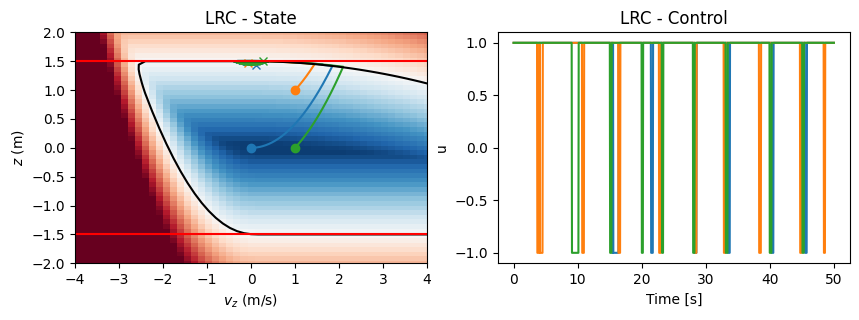

In [10]:
# Initial conditions
initial_conditions = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([0.0, 1.0])
]

# Nominal trajectories
trajs1 = [simulate(ic, lrc, dt=0.005) for ic in initial_conditions]
plot_trajectories(trajs1, title="LRC")

# Smooth Least Restrictive Controller

In [11]:
# Setting up the QP
def qp_controller(state, gamma=1.0):
    h_val = v(state)
    dh = grad_v(state)
    u_nom = nominal_controller(state)
    opt_d = dynamics.optimal_disturbance(state, 0.0, grad_v(state))

    def objective(u):
        return np.sum((u - u_nom)**2)

    # import pdb; pdb.set_trace()
    def constraint(u):
        return (dh @ dynamics.open_loop_dynamics(state, 0)) + (dh @ dynamics.control_jacobian(state, 0)) * u + (dh @ dynamics.disturbance_jacobian(state, 0)) * opt_d + gamma * h_val

    bounds = [(-u_bar, u_bar)]
    con = {'type': 'ineq', 'fun': constraint}

    res = minimize(objective, u_nom, bounds=bounds, constraints=[con])
    return res.x if res.success else dynamics.optimal_control(state, 0.0, dh)

# Smooth Least Restrictive Controller
def smooth_lrc(state):
    if v(state) > 0:
        return nominal_controller(state)
    else:
        return qp_controller(state, 0.0)

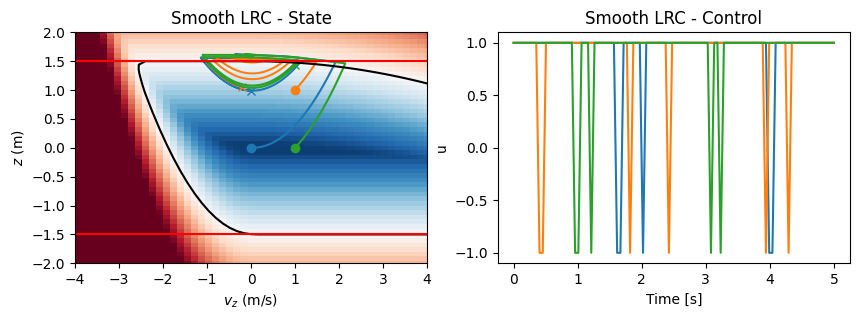

In [12]:
# Initial conditions
initial_conditions = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([0.0, 1.0])
]

# Nominal trajectories
trajs1 = [simulate(ic, smooth_lrc, dt=0.05) for ic in initial_conditions]
plot_trajectories(trajs1, title="Smooth LRC")

# Smooth Blending Filter

In [13]:
def run_cbf_qp(gamma):
    controller = lambda x: qp_controller(x, gamma=gamma)
    trajs = [simulate(ic, controller, dt=0.05) for ic in initial_conditions]
    plot_trajectories(trajs, title=f"Smooth Blending gamma = {gamma}")

interact(run_cbf_qp, gamma=FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1, description='Gamma'))

interactive(children=(FloatSlider(value=5.0, description='Gamma', max=10.0), Output()), _dom_classes=('widget-…

<function __main__.run_cbf_qp(gamma)>